# Delta Function Appeal

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import pickle

np.random.seed(42)

In [2]:
import os

if os.path.isdir("../notebooks"):
    os.chdir("..")

from utils import viz, delta_function, generate_init


from agent import Person

from model import VirusModel, VirusModel_baseline




## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


In [3]:
# values = plt.hist(np.random.beta(1.5, 5, 10000),

#                   bins=200, density=True)

# plt.show()

In [4]:
# import matplotlib.pyplot as plt

# values = plt.hist(np.random.beta(5, 3, 10000),

#                   bins=200, density=True)

# plt.show()

Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

In [15]:
parameters = {
    'my_parameter':42,
    'agents':500,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': ap.IntRange(0.25,0.3), # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': 'hist', # None, 'hist'
    'expi': None
    
}
sample = ap.Sample(parameters, n=1)
model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =20, record = True)
results_baseline = exp.run() 

with open("data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_baseline = results_baseline['variables']['Person']



Scheduled runs: 20
0.5915
Completed: 1, estimated time remaining: 0:03:560.5665
Completed: 2, estimated time remaining: 0:03:380.565
Completed: 3, estimated time remaining: 0:03:240.6075
Completed: 4, estimated time remaining: 0:03:110.607
Completed: 5, estimated time remaining: 0:03:000.576
Completed: 6, estimated time remaining: 0:02:490.55
Completed: 7, estimated time remaining: 0:02:390.574
Completed: 8, estimated time remaining: 0:02:260.5855
Completed: 9, estimated time remaining: 0:02:130.59
Completed: 10, estimated time remaining: 0:02:010.5845
Completed: 11, estimated time remaining: 0:01:490.598
Completed: 12, estimated time remaining: 0:01:360.5945
Completed: 13, estimated time remaining: 0:01:240.6085
Completed: 14, estimated time remaining: 0:01:120.587
Completed: 15, estimated time remaining: 0:01:000.5695
Completed: 16, estimated time remaining: 0:00:480.612
Completed: 17, estimated time remaining: 0:00:360.601
Completed: 18, estimated time remaining: 0:00:240.6085
Compl

In [26]:
df_baseline['misclassifications'] = (df_baseline['fraud'] - df_baseline['fraud_pred'])
df_baseline[df_baseline['fraud_pred'] ==0]['wealth'].min()

df_baseline.head()
df_baseline = df_baseline[df_baseline.fraud_pred != -1]
df_baseline

/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_58335/3302079312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baseline['misclassifications'] = (df_baseline['fraud'] - df_baseline['fraud_pred'])


wealth  fraud_pred  fraud  race  gender  convicted  \
iteration obj_id t                                                           
0         1      1    0.286444           0      0     0       0          0   
                 2    0.294649           0      0     0       0          0   
                 3    0.303330           0      0     0       0          0   
                 4    0.312531           0      1     0       0          0   
                 5    0.322299           0      0     0       0          0   
...                        ...         ...    ...   ...     ...        ...   
19        500    96   1.000000           0      0     0       0          0   
                 97   1.000000           0      0     0       0          0   
                 98   1.000000           0      0     0       0          0   
                 99   1.000000           0      1     0       0          0   
                 100  1.000000           0      1     0       0          0   

                      misclassifications  
iteration obj_id t                        
0         1      1                     0  
                 2                     0  
                 3                     0  
                 4                     1  
                 5                     0  
...                                  ...  
19        500    96                    0  
                 97                    0  
                 98                    0  
                 99                    1  
                 100                   1  

[1000000 rows x 7 columns]

In [37]:
def viz2(data, x, y):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 marker = 'o')
    
    # plt.ylim(0,0.2)
    plt.xlim(0,50)

    plt.show()

In [17]:
def viz(data, x, y, hue, title = None):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 hue = hue,
                 marker = 'o')
    
    # plt.ylim(0,0.2)
    plt.xlim(0,50)
    plt.title(title)

    plt.show()

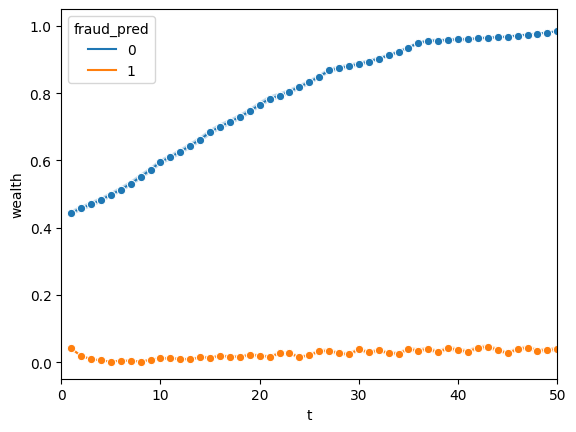

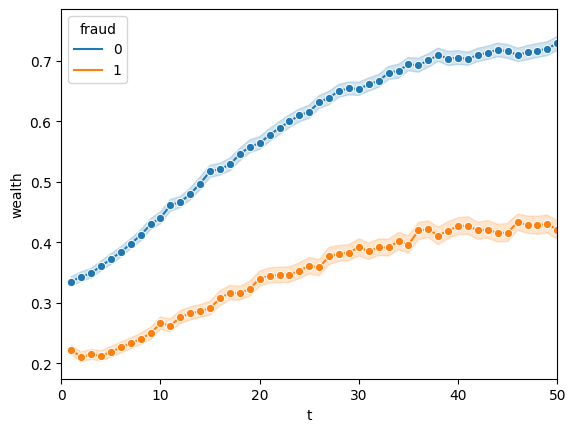

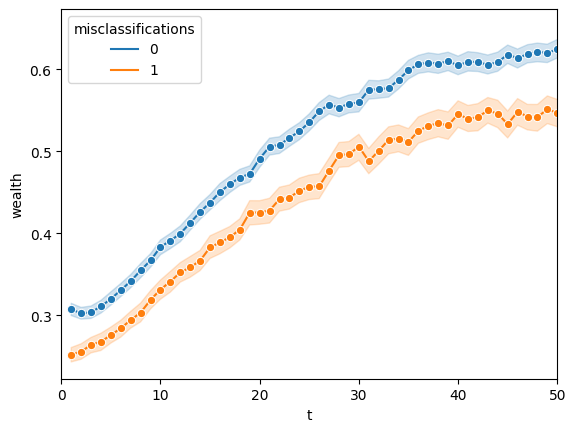

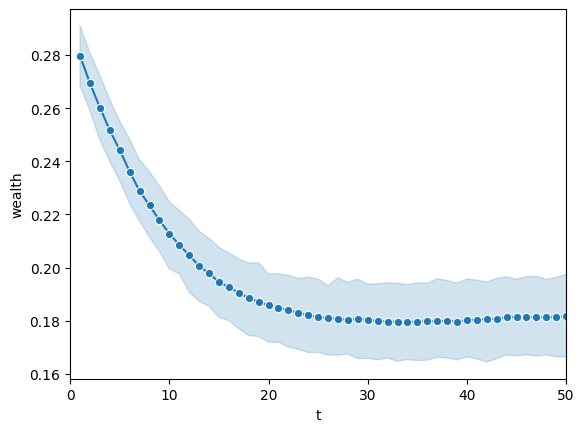

In [38]:
viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], df_baseline['fraud_pred']) #, df_baseline['convicted'])

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], df_baseline['fraud']) #, df_baseline['convicted'])

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], abs(df_baseline['misclassifications'])) #, df_baseline['convicted'])

viz2(df_b, df_b.index.get_level_values('t'), df_b['wealth'])

# viz(df_baseline, df_baseline.index.get_level_values('t'), abs(df_baseline['fraud'] - df_baseline['fraud_pred']), df_baseline['race'])#, df_baseline['fraud'])

In [ ]:
# create baseline value fraud prediction medium income

df_b1 = df_baseline.iloc[(df_baseline['fraud_pred'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

baseline0
df_b0
df_baseline.head(400)
baseline1
# df_x1 = df.iloc[(df_baseline['fraud_pred'] == 1).values] 
# df_wb1 = df_x1['wealth'] - baseline1['wealth']
# df_x1['wealth'] = df_wb1




# df_x0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
# df_wb0 = df_x0['wealth'] - baseline0['wealth']
# df_x0['wealth'] = df_wb0

# df_xb = pd.concat([df_x0, df_x1])

# df_xb

/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_57540/2897906450.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  baseline1 = df_b1.groupby(level='t').mean()
/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_57540/2897906450.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  baseline0 = df_b0.groupby(level='t').mean()


,wealth,fraud_pred,race,gender,convicted
t,,,,,
1,0.048510,1.0,0.265997,0.413049,1.0
2,0.025493,1.0,0.266550,0.412738,1.0
3,0.015536,1.0,0.267651,0.413871,1.0
4,0.006734,1.0,0.268660,0.415431,1.0
5,0.006002,1.0,0.266550,0.412738,1.0
...,...,...,...,...,...
96,0.025853,1.0,0.272861,0.406112,1.0
97,0.028194,1.0,0.277264,0.404576,1.0
98,0.036699,1.0,0.272486,0.401013,1.0


In [54]:
parameters = {
    'my_parameter':42,
    'agents':500,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.6, # accuracy of fraud prdediction
    'appeal_wealth': 0.3, # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': None, # None, 'hist'
    'expi': None
    
}
sample = ap.Sample(parameters, n=1)
model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =20, record = True)
r_baseline = exp.run() 

with open("data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_b = r_baseline['variables']['Person']


Scheduled runs: 20
Completed: 20, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:31.575345


In [55]:
df_b['misclassifications'] = (df_b['fraud'] - df_b['fraud_pred'])
df_b[df_b['fraud_pred'] ==0]['wealth'].min()

df_b.head()
df_b = df_b[df_b.fraud_pred != -1]
df_b

wealth  fraud_pred  fraud  race  gender  convicted  \
iteration obj_id t                                                           
0         1      1    0.348765           0      0     1       0          0   
                 2    0.360928           0      0     1       0          0   
                 3    0.373955           0      1     1       0          0   
                 4    0.334450           1      1     1       0          1   
                 5    0.292541           1      1     1       0          1   
...                        ...         ...    ...   ...     ...        ...   
19        500    96   0.000000           0      1     0       0          1   
                 97   0.000000           0      0     0       0          1   
                 98   0.000000           1      1     0       0          1   
                 99   0.000000           0      1     0       0          1   
                 100  0.000000           1      1     0       0          1   

                      misclassifications  
iteration obj_id t                        
0         1      1                     0  
                 2                     0  
                 3                     1  
                 4                     0  
                 5                     0  
...                                  ...  
19        500    96                    1  
                 97                    0  
                 98                    0  
                 99                    1  
                 100                   0  

[1000000 rows x 7 columns]

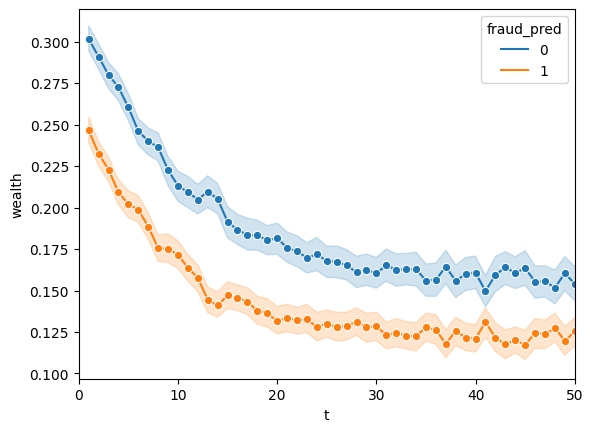

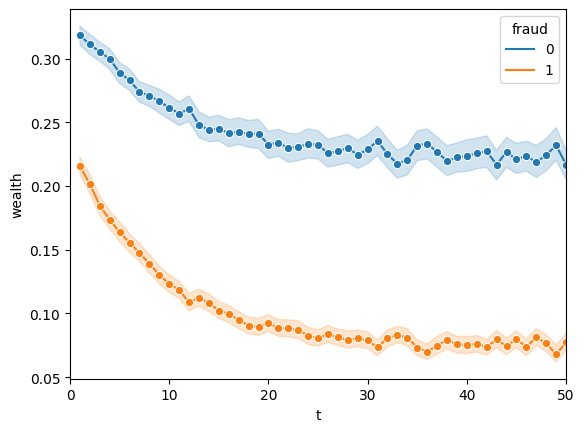

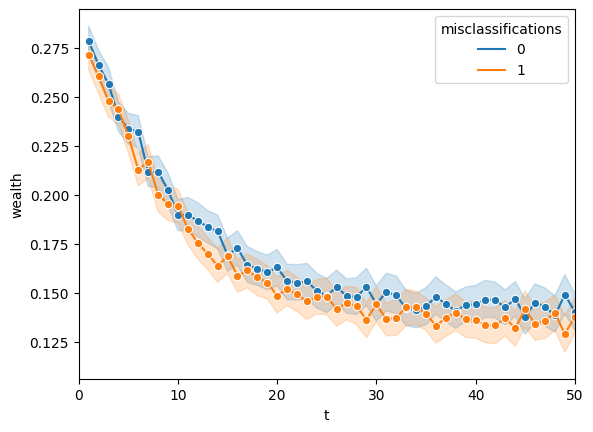

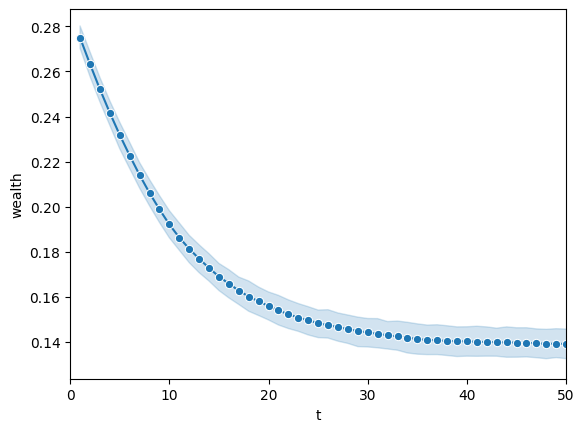

In [56]:
viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud_pred']) #, df_baseline['convicted'])

viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], df_b['fraud']) #, df_baseline['convicted'])

viz(df_b, df_b.index.get_level_values('t'), df_b['wealth'], abs(df_b['misclassifications']), title = 'Misclassification depending on wealth over time') #, df_baseline['convicted'])

viz2(df_b, df_b.index.get_level_values('t'), df_b['wealth'])

# viz(df_baseline, df_baseline.index.get_level_values('t'), abs(df_baseline['fraud'] - df_baseline['fraud_pred']), df_baseline['race'])#, df_baseline['fraud'])